
<a id='lake-model'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# A Lake Model of Employment and Unemployment


<a id='index-0'></a>

## Contents

- [A Lake Model of Employment and Unemployment](#A-Lake-Model-of-Employment-and-Unemployment)  
  - [Overview](#Overview)  
  - [The Model](#The-Model)  
  - [Implementation](#Implementation)  
  - [Dynamics of an Individual Worker](#Dynamics-of-an-Individual-Worker)  
  - [Endogenous Job Finding Rate](#Endogenous-Job-Finding-Rate)  
  - [Exercises](#Exercises)  
  - [Solutions](#Solutions)  

## Overview

This lecture describes what has come to be called a *lake model*

The lake model is a basic tool for modeling unemployment

It allows us to analyze

- flows between unemployment and employment  
- how these flows influence steady state employment and unemployment rates  


It is a good model for interpreting monthly labor department reports on gross and net jobs created and jobs destroyed

The “lakes” in the model are the pools of employed and unemployed

The “flows” between the lakes are caused by

- firing and hiring  
- entry and exit from the labor force  


For the first part of this lecture, the parameters governing transitions into
and out of unemployment and employment are exogenous

Later, we’ll determine some of these transition rates endogenously using the [McCall search model](dynamic_programming/mccall_model.html)

We’ll also use some nifty concepts like ergodicity, which provides a fundamental link between *cross-sectional* and *long run time series* distributions

These concepts will help us build an equilibrium model of ex ante homogeneous workers whose different luck generates variations in their ex post experiences

### Prerequisites

Before working through what follows, we recommend you read the [lecture
on finite Markov chains](tools_and_techniques/finite_markov.html)

You will also need some basic [linear algebra](tools_and_techniques/linear_algebra.html) and probability

## The Model

The economy is inhabited by a very large number of ex ante identical workers

The workers live forever, spending their lives moving between unemployment and employment

Their rates of  transition between employment and unemployment are  governed by the following parameters:

- $ \lambda $, the job finding rate for currently unemployed workers  
- $ \alpha $, the dismissal rate for currently employed workers  
- $ b $, the entry rate into the labor force  
- $ d $, the exit rate from the labor force  


The growth rate of the labor force evidently equals $ g=b-d $

### Aggregate Variables

We want to derive the dynamics of the following aggregates

- $ E_t $, the total number of employed workers at date $ t $  
- $ U_t $, the total number of unemployed workers at $ t $  
- $ N_t $, the number of workers in the labor force at $ t $  


We also want to know the values of the following objects

- The employment rate $ e_t := E_t/N_t $  
- The unemployment rate $ u_t := U_t/N_t $  


(Here and below, capital letters represent stocks and lowercase letters represent flows)

### Laws of Motion for Stock Variables

We begin by constructing laws of motion for the aggregate variables $ E_t,U_t, N_t $

Of the mass of workers $ E_t $ who are employed at date $ t $,

- $ (1-d)E_t $ will remain in the labor force  
- of these, $ (1-\alpha)(1-d)E_t $ will remain employed  


Of the mass of workers $ U_t $ workers who are currently unemployed,

- $ (1-d)U_t $ will remain in the labor force  
- of these, $ (1-d) \lambda U_t $ will become employed  


Therefore,  the number of workers who will be employed at date $ t+1 $ will be

$$
E_{t+1} = (1-d)(1-\alpha)E_t + (1-d)\lambda U_t
$$

A similar analysis implies

$$
U_{t+1} = (1-d)\alpha E_t + (1-d)(1-\lambda)U_t + b (E_t+U_t)
$$

The value $ b(E_t+U_t) $ is the mass of new workers entering the labor force unemployed

The total stock of workers $ N_t=E_t+U_t $ evolves as

$$
N_{t+1} = (1+b-d)N_t = (1+g)N_t
$$

Letting $ X_t := \left(\begin{matrix}U_t\\E_t\end{matrix}\right) $, the law of motion for $ X $  is

$$
X_{t+1} = A X_t
\quad \text{where} \quad
A :=
\begin{pmatrix}
    (1-d)(1-\lambda) + b & (1-d)\alpha + b  \\
    (1-d)\lambda & (1-d)(1-\alpha)
\end{pmatrix}
$$

This law tells us how total employment and unemployment evolve over time

### Laws of Motion for Rates

Now let’s derive the law of motion for rates

To get these we can divide both sides of $ X_{t+1} = A X_t $ by  $ N_{t+1} $ to get

$$
\begin{pmatrix}
    U_{t+1}/N_{t+1} \\
    E_{t+1}/N_{t+1}
\end{pmatrix}
=
\frac1{1+g} A
\begin{pmatrix}
    U_{t}/N_{t}
    \\
    E_{t}/N_{t}
\end{pmatrix}
$$

Letting

$$
x_t :=
\left(\begin{matrix}
    u_t\\ e_t
\end{matrix}\right)
= \left(\begin{matrix}
    U_t/N_t\\ E_t/N_t
\end{matrix}\right)
$$

we can also write this as

$$
x_{t+1} = \hat A x_t
\quad \text{where} \quad
\hat A := \frac{1}{1 + g} A
$$

You can check that $ e_t + u_t = 1 $ implies that $ e_{t+1}+u_{t+1} = 1 $

This follows from the fact that the columns of $ \hat A $ sum to 1

## Implementation

Let’s code up these equations

Here’s the code:

### Setup

In [1]:
using InstantiateFromURL
activate_github("QuantEcon/QuantEconLecturePackages", tag = "v0.9.8");

In [2]:
using LinearAlgebra, Statistics, Compat
using Distributions, Expectations, NLsolve, Parameters, Plots
using QuantEcon, Roots, Random

In [3]:
gr(fmt = :png);

In [4]:
LakeModel = @with_kw (λ = 0.283, α = 0.013, b = 0.0124, d = 0.00822)

function transition_matrices(lm)
    @unpack λ, α, b, d = lm
    g = b - d
    A = [(1 - λ) * (1 - d) + b      (1 - d) * α + b
        (1 - d) * λ                 (1 - d) * (1 - α)]
    Â = A ./ (1 + g)
    return (A = A, Â = Â)
end

function rate_steady_state(lm)
    @unpack Â = transition_matrices(lm)
    sol = fixedpoint(x -> Â * x, fill(0.5, 2))
    converged(sol) || error("Failed to converge in $(result.iterations) iterations")
    return sol.zero
end

function simulate_stock_path(lm, X0, T)
    @unpack A = transition_matrices(lm)
    X_path = zeros(eltype(X0), 2, T)
    X = copy(X0)
    for t in 1:T
        X_path[:, t] = X
        X = A * X
    end
    return X_path
end

function simulate_rate_path(lm, x0, T)
    @unpack Â = transition_matrices(lm)
    x_path = zeros(eltype(x0), 2, T)
    x = copy(x0)
    for t in 1:T
        x_path[:, t] = x
        x = Â * x
    end
    return x_path
end

simulate_rate_path (generic function with 1 method)

Let’s observe these matrices for the baseline model

In [5]:
lm = LakeModel()
A, Â = transition_matrices(lm)
A

2×2 Array{Float64,2}:
 0.723506  0.0252931
 0.280674  0.978887 

In [6]:
Â

2×2 Array{Float64,2}:
 0.720495  0.0251879
 0.279505  0.974812 

And a revised model

In [7]:
lm = LakeModel(α = 2.0)
A, Â = transition_matrices(lm)
A

2×2 Array{Float64,2}:
 0.723506   1.99596
 0.280674  -0.99178

In [8]:
Â

2×2 Array{Float64,2}:
 0.720495   1.98765 
 0.279505  -0.987652

### Aggregate Dynamics

Let’s run a simulation under the default parameters (see above) starting from $ X_0 = (12, 138) $

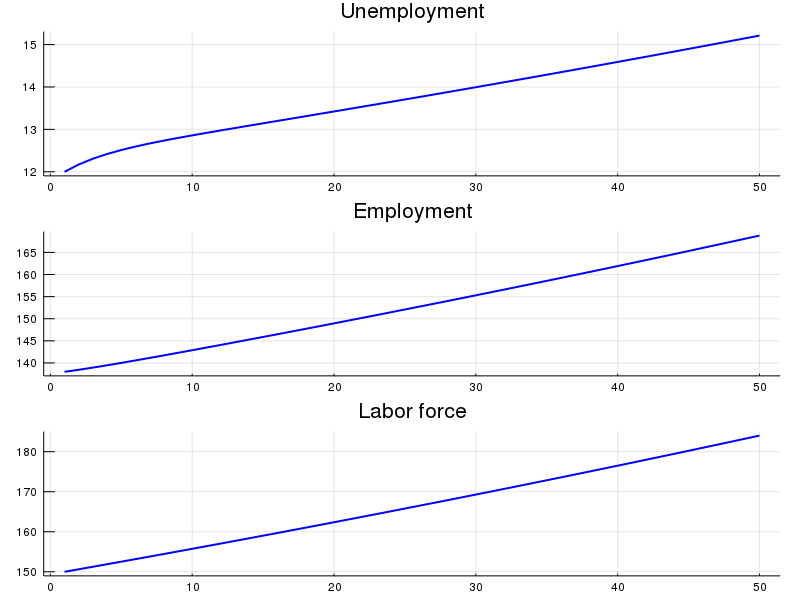

In [9]:
lm = LakeModel()
N_0 = 150      # population
e_0 = 0.92     # initial employment rate
u_0 = 1 - e_0  # initial unemployment rate
T = 50         # simulation length

U_0 = u_0 * N_0
E_0 = e_0 * N_0
X_0 = [U_0; E_0]

X_path = simulate_stock_path(lm, X_0, T)

x1 = X_path[1, :]
x2 = X_path[2, :]
x3 = dropdims(sum(X_path, dims = 1), dims = 1)

plt_unemp = plot(title = "Unemployment", 1:T, x1, color = :blue, lw = 2, grid = true, label = "")
plt_emp = plot(title = "Employment", 1:T, x2, color = :blue, lw = 2, grid = true, label = "")
plt_labor = plot(title = "Labor force", 1:T, x3, color = :blue, lw = 2, grid = true, label = "")

plot(plt_unemp, plt_emp, plt_labor, layout = (3, 1), size = (800, 600))

The aggregates $ E_t $ and $ U_t $ don’t converge because  their sum $ E_t + U_t $ grows at rate $ g $

On the other hand, the vector of employment and unemployment rates $ x_t $ can be in a steady state $ \bar x $ if
there exists an $ \bar x $  such that

- $ \bar x = \hat A \bar x $  
- the components satisfy $ \bar e + \bar u = 1 $  


This equation tells us that a steady state level $ \bar x $ is an  eigenvector of $ \hat A $ associated with a unit eigenvalue

We also have $ x_t \to \bar x $ as $ t \to \infty $ provided that the remaining eigenvalue of $ \hat A $ has modulus less that 1

This is the case for our default parameters:

In [10]:
lm = LakeModel()
A, Â = transition_matrices(lm)
e, f = eigvals(Â)
abs(e), abs(f)

(0.6953067378358462, 1.0)

Let’s look at the convergence of the unemployment and employment rate to steady state levels (dashed red line)

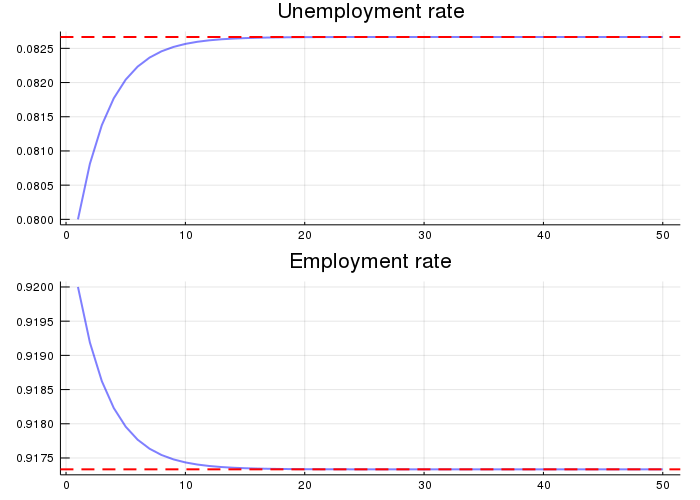

In [11]:
lm = LakeModel()
e_0 = 0.92     # initial employment rate
u_0 = 1 - e_0  # initial unemployment rate
T = 50         # simulation length

xbar = rate_steady_state(lm)
x_0 = [u_0; e_0]
x_path = simulate_rate_path(lm, x_0, T)

plt_unemp = plot(title ="Unemployment rate", 1:T, x_path[1, :],color = :blue, lw = 2,
                 alpha = 0.5, grid = true, label = "")
plot!(plt_unemp, [xbar[1]], color=:red, linetype = :hline, linestyle = :dash, lw = 2, label = "")
plt_emp = plot(title = "Employment rate", 1:T, x_path[2, :],color = :blue, lw = 2, alpha = 0.5,
               grid = true, label = "")
plot!(plt_emp, [xbar[2]], color=:red, linetype = :hline, linestyle = :dash, lw = 2, label = "")
plot(plt_unemp, plt_emp, layout = (2, 1), size=(700,500))

## Dynamics of an Individual Worker

An individual worker’s employment dynamics are governed by a [finite state Markov process](tools_and_techniques/finite_markov.html)

The worker can be in one of two states:

- $ s_t=0 $ means unemployed  
- $ s_t=1 $ means employed  


Let’s start off under the assumption that $ b = d = 0 $

The associated transition matrix is then

$$
P = \left(
        \begin{matrix}
            1 - \lambda & \lambda \\
            \alpha & 1 - \alpha
        \end{matrix}
    \right)
$$

Let $ \psi_t $ denote the [marginal distribution](tools_and_techniques/finite_markov.html#mc-md) over employment / unemployment states for the worker at time $ t $

As usual, we regard it as a row vector

We know [from an earlier discussion](tools_and_techniques/finite_markov.html#mc-md) that $ \psi_t $ follows the law of motion

$$
\psi_{t+1} = \psi_t P
$$

We also know from the [lecture on finite Markov chains](tools_and_techniques/finite_markov.html)
that if $ \alpha \in (0, 1) $ and $ \lambda \in (0, 1) $, then
$ P $ has a unique stationary distribution, denoted here by $ \psi^* $

The unique stationary distribution satisfies

$$
\psi^*[0] = \frac{\alpha}{\alpha + \lambda}
$$

Not surprisingly, probability mass on the unemployment state increases with
the dismissal rate and falls with the job finding rate rate

### Ergodicity

Let’s look at a typical lifetime of employment-unemployment spells

We want to compute the average amounts of time an infinitely lived worker would spend employed and unemployed

Let

$$
\bar s_{u,T} := \frac1{T} \sum_{t=1}^T \mathbb 1\{s_t = 0\}
$$

and

$$
\bar s_{e,T} := \frac1{T} \sum_{t=1}^T \mathbb 1\{s_t = 1\}
$$

(As usual, $ \mathbb 1\{Q\} = 1 $ if statement $ Q $ is true and 0 otherwise)

These are the fraction of time a worker spends unemployed and employed, respectively, up until period $ T $

If $ \alpha \in (0, 1) $ and $ \lambda \in (0, 1) $, then $ P $ is [ergodic](tools_and_techniques/finite_markov.html#ergodicity), and hence we have

$$
\lim_{T \to \infty} \bar s_{u, T} = \psi^*[0]
\quad \text{and} \quad
\lim_{T \to \infty} \bar s_{e, T} = \psi^*[1]
$$

with probability one

Inspection tells us that $ P $ is exactly the transpose of $ \hat A $ under the assumption $ b=d=0 $

Thus, the percentages of time that an  infinitely lived worker  spends employed and unemployed equal the fractions of workers employed and unemployed in the steady state distribution

### Convergence rate

How long does it take for time series sample averages to converge to cross sectional averages?

We can use [QuantEcon.jl’s](http://quantecon.org/julia_index.html)
MarkovChain type to investigate this

Let’s plot the path of the sample averages over 5,000 periods

In [12]:
using QuantEcon, Roots, Random

In [13]:
lm = LakeModel(d = 0, b = 0)
T = 5000                        # Simulation length

@unpack α, λ = lm
P = [(1 - λ)     λ
     α      (1 - α)]

2×2 Array{Float64,2}:
 0.717  0.283
 0.013  0.987

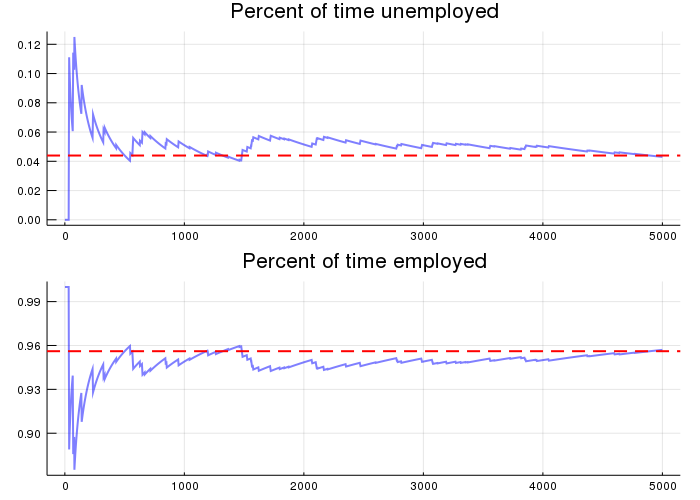

In [14]:
Random.seed!(42)
mc = MarkovChain(P, [0; 1])     # 0=unemployed, 1=employed
xbar = rate_steady_state(lm)

s_path = simulate(mc, T; init=2)
s̄_e = cumsum(s_path) ./ (1:T)
s̄_u = 1 .- s̄_e
s_bars = [s̄_u s̄_e]

plt_unemp = plot(title = "Percent of time unemployed", 1:T, s_bars[:,1],color = :blue, lw = 2,
                 alpha = 0.5, label = "", grid = true)
plot!(plt_unemp, [xbar[1]], linetype = :hline, linestyle = :dash, color=:red, lw = 2, label = "")
plt_emp = plot(title = "Percent of time employed", 1:T, s_bars[:,2],color = :blue, lw = 2,
               alpha = 0.5, label = "", grid = true)
plot!(plt_emp, [xbar[2]], linetype = :hline, linestyle = :dash, color=:red, lw = 2, label = "")
plot(plt_unemp, plt_emp, layout = (2, 1), size=(700,500))

The stationary probabilities are given by the dashed red line

In this case it takes much of the sample for these two objects to converge

This is largely due to the high persistence in the Markov chain

## Endogenous Job Finding Rate

We now make the hiring rate endogenous

The transition rate from unemployment to employment will be determined by the McCall search model [[McC70]](zreferences.html#mccall1970)

All details relevant to the following discussion can be found in [our treatment](dynamic_programming/mccall_model.html) of that model

### Reservation Wage

The most important thing to remember about the model is that optimal decisions
are characterized by a reservation wage $ \bar w $

- If the wage offer $ w $ in hand is greater than or equal to $ \bar w $, then the worker accepts  
- Otherwise, the worker rejects  


As we saw in [our discussion of the model](dynamic_programming/mccall_model.html), the reservation wage depends on the wage offer distribution and the parameters

- $ \alpha $, the separation rate  
- $ \beta $, the discount factor  
- $ \gamma $, the offer arrival rate  
- $ c $, unemployment compensation  

### Linking the McCall Search Model to the Lake Model

Suppose that  all workers inside a lake model behave according to the McCall search model

The exogenous probability of leaving employment remains $ \alpha $

But their optimal decision rules determine the probability $ \lambda $ of leaving unemployment

This is now


<a id='equation-lake-lamda'></a>
$$
\lambda
= \gamma \mathbb P \{ w_t \geq \bar w\}
= \gamma \sum_{w' \geq \bar w} p(w') \tag{1}
$$

### Fiscal Policy

We can use the McCall search version of the Lake Model  to find an optimal level of unemployment insurance

We assume that  the government sets unemployment compensation $ c $

The government imposes a lump sum tax $ \tau $ sufficient to finance total unemployment payments

To attain a balanced budget at a steady state, taxes, the steady state unemployment rate $ u $, and the unemployment compensation rate must satisfy

$$
\tau = u c
$$

The lump sum tax applies to everyone, including unemployed workers

Thus, the post-tax income of an employed worker with wage $ w $ is $ w - \tau $

The post-tax income of an unemployed worker is $ c - \tau $

For each specification $ (c, \tau) $ of government policy, we can solve for the worker’s optimal reservation wage

This determines $ \lambda $ via [(1)](#equation-lake-lamda) evaluated at post tax wages, which in turn determines a steady state unemployment rate $ u(c, \tau) $

For a given level of unemployment benefit $ c $, we can solve for a tax that balances the budget in the steady state

$$
\tau = u(c, \tau) c
$$

To evaluate alternative government tax-unemployment compensation pairs, we require a welfare criterion

We use a steady state welfare criterion

$$
W := e \,  {\mathbb E} [V \, | \,  \text{employed}] + u \,  U
$$

where the notation $ V $ and $ U $ is as defined in the [McCall search model lecture](dynamic_programming/mccall_model.html)

The wage offer distribution will be a discretized version of the lognormal distribution $ LN(\log(20),1) $, as shown in the next figure

<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/jl/_static/figures/lake_distribution_wages.png" style="width:80%;height:80%">

  
We take a period to be a month

We set $ b $ and $ d $ to match monthly [birth](http://www.cdc.gov/nchs/fastats/births.htm) and [death rates](http://www.cdc.gov/nchs/fastats/deaths.htm), respectively, in the U.S. population

- $ b = 0.0124 $  
- $ d = 0.00822 $  


Following [[DFH06]](zreferences.html#davis2006flow), we set $ \alpha $, the hazard rate of leaving employment, to

- $ \alpha = 0.013 $  

### Fiscal Policy Code

We will make use of (with some tweaks) the code we wrote in the [McCall model lecture](dynamic_programming/mccall_model.html), embedded below for convenience

In [15]:
function solve_mccall_model(mcm; U_iv = 1.0, V_iv = ones(length(mcm.w)), tol = 1e-5,
                            iter = 2_000)
    @unpack α, β, σ, c, γ, w, E, u = mcm

    # necessary objects
    u_w = u.(w, σ)
    u_c = u(c, σ)

    # Bellman operator T. Fixed point is x* s.t. T(x*) = x*
    function T(x)
        V = x[1:end-1]
        U = x[end]
        [u_w + β * ((1 - α) * V .+ α * U); u_c + β * (1 - γ) * U + β * γ * E * max.(U, V)]
    end

    # value function iteration
    x_iv = [V_iv; U_iv] # initial x val
    xstar = fixedpoint(T, x_iv, iterations = iter, xtol = tol).zero
    V = xstar[1:end-1]
    U = xstar[end]

    # compute the reservation wage
    w_barindex = searchsortedfirst(V .- U, 0.0)
    if w_barindex >= length(w) # if this is true, you never want to accept
        w̄ = Inf
    else
        w̄ = w[w_barindex] # otherwise, return the number
    end

    # return a NamedTuple, so we can select values by name
    return (V = V, U = U, w̄ = w̄)
end

solve_mccall_model (generic function with 1 method)

And the McCall object

In [16]:
# a default utility function
u(c, σ) = c > 0 ? (c^(1 - σ) - 1) / (1 - σ) : -10e-6

# model constructor
McCallModel = @with_kw (α = 0.2,
                        β = 0.98, # discount rate
                        γ = 0.7,
                        c = 6.0, # unemployment compensation
                        σ = 2.0,
                        u = u, # utility function
                        w = range(10, 20, length = 60), # wage values
                        E = Expectation(BetaBinomial(59, 600, 400))) # distribution over wage values

#10 (generic function with 2 methods)

Now let’s compute and plot welfare, employment, unemployment, and tax revenue as a
function of the unemployment compensation rate

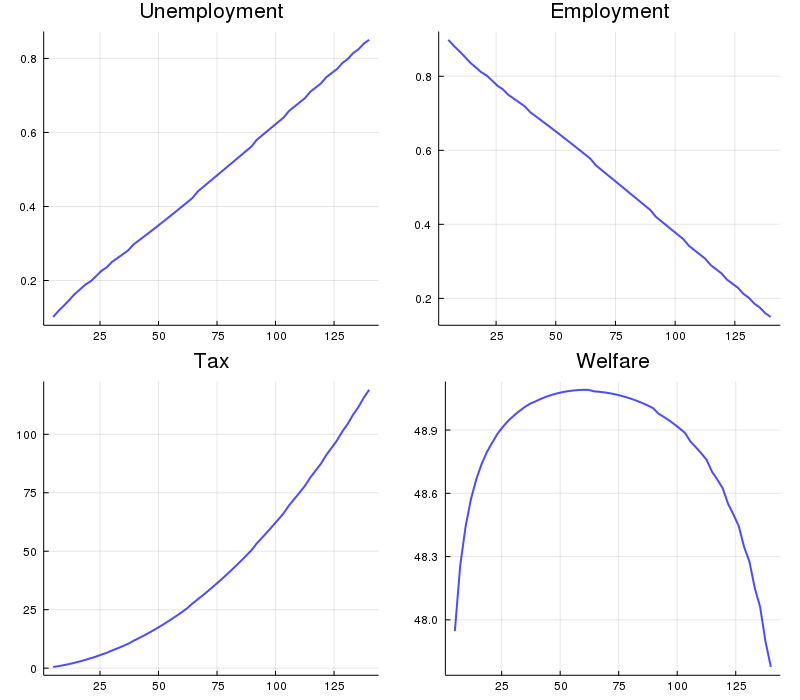

In [17]:
# some global variables that will stay constant
α = 0.013
α_q = (1 - (1 - α)^3)
b_param = 0.0124
d_param = 0.00822
β = 0.98
γ = 1.0
σ = 2.0

# the default wage distribution: a discretized log normal
log_wage_mean, wage_grid_size, max_wage = 20, 200, 170
w_vec = range(1e-3, max_wage, length = wage_grid_size + 1)

logw_dist = Normal(log(log_wage_mean), 1)
cdf_logw = cdf.(logw_dist, log.(w_vec))
pdf_logw = cdf_logw[2:end] - cdf_logw[1:end-1]

p_vec = pdf_logw ./ sum(pdf_logw)
w_vec = (w_vec[1:end-1] + w_vec[2:end]) / 2

E = expectation(Categorical(p_vec)) # expectation object

function compute_optimal_quantities(c, τ)
    mcm = McCallModel(α = α_q,
                      β = β,
                      γ = γ,
                      c = c - τ, # post-tax compensation
                      σ = σ,
                      w = w_vec .- τ, # post-tax wages
                      E = E) # expectation operator

    @unpack V, U, w̄ = solve_mccall_model(mcm)
    indicator = wage -> wage > w̄
    λ = γ * E * indicator.(w_vec .- τ)

    return w̄, λ, V, U
end

function compute_steady_state_quantities(c, τ)
    w̄, λ_param, V, U = compute_optimal_quantities(c, τ)

    # compute steady state employment and unemployment rates
    lm = LakeModel(λ = λ_param, α = α_q, b = b_param, d = d_param)
    x = rate_steady_state(lm)
    u_rate, e_rate = x

    # compute steady state welfare
    indicator(wage) = wage > w̄
    indicator(wage) = wage > w̄
    decisions = indicator.(w_vec .- τ)
    w = (E * (V .* decisions)) / (E * decisions)
    welfare = e_rate .* w + u_rate .* U

    return u_rate, e_rate, welfare
end

function find_balanced_budget_tax(c)
    function steady_state_budget(t)
        u_rate, e_rate, w = compute_steady_state_quantities(c, t)
        return t - u_rate * c
    end

    τ = find_zero(steady_state_budget, (0.0, 0.9c))
    return τ
end

# levels of unemployment insurance we wish to study
Nc = 60
c_vec = range(5, 140, length = Nc)

tax_vec = zeros(Nc)
unempl_vec = similar(tax_vec)
empl_vec = similar(tax_vec)
welfare_vec = similar(tax_vec)

for i in 1:Nc
    t = find_balanced_budget_tax(c_vec[i])
    u_rate, e_rate, welfare = compute_steady_state_quantities(c_vec[i], t)
    tax_vec[i] = t
    unempl_vec[i] = u_rate
    empl_vec[i] = e_rate
    welfare_vec[i] = welfare
end

plt_unemp = plot(title = "Unemployment", c_vec, unempl_vec, color = :blue, lw = 2, alpha=0.7,
                 label = "",grid = true)
plt_tax = plot(title = "Tax", c_vec, tax_vec, color = :blue, lw = 2, alpha=0.7, label = "",
               grid = true)
plt_emp = plot(title = "Employment", c_vec, empl_vec, color = :blue, lw = 2, alpha=0.7, label = "",
               grid = true)
plt_welf = plot(title = "Welfare", c_vec, welfare_vec, color = :blue, lw = 2, alpha=0.7, label = "",
                grid = true)

plot(plt_unemp, plt_emp, plt_tax, plt_welf, layout = (2,2), size = (800, 700))

Welfare first increases and then decreases as unemployment benefits rise

The level that maximizes steady state welfare is approximately 62

## Exercises

### Exercise 1

Consider an economy with initial stock  of workers $ N_0 = 100 $ at the
steady state level of employment in the baseline parameterization

- $ \alpha = 0.013 $  
- $ \lambda = 0.283 $  
- $ b = 0.0124 $  
- $ d = 0.00822 $  


(The values for $ \alpha $ and $ \lambda $ follow [[DFH06]](zreferences.html#davis2006flow))

Suppose that in response to new legislation the hiring rate reduces to $ \lambda = 0.2 $

Plot the transition dynamics of the unemployment and employment stocks for 50 periods

Plot the transition dynamics for the rates

How long does the economy take to converge to its new steady state?

What is the new steady state level of employment?

### Exercise 2

Consider an economy with initial stock  of workers $ N_0 = 100 $ at the
steady state level of employment in the baseline parameterization

Suppose that for 20 periods the birth rate was temporarily high ($ b = 0.0025 $) and then returned to its original level

Plot the transition dynamics of the unemployment and employment stocks for 50 periods

Plot the transition dynamics for the rates

How long does the economy take to return to its original steady state?

## Solutions

### Exercise 1

We begin by constructing an object containing the default parameters and assigning the
steady state values to x0

In [18]:
lm = LakeModel()
x0 = rate_steady_state(lm)
println("Initial Steady State: $x0")

Initial Steady State: [0.0826663, 0.917334]


Initialize the simulation values

In [19]:
N0 = 100
T = 50

50

New legislation changes $ \lambda $ to $ 0.2 $

In [20]:
lm = LakeModel(λ = 0.2)

(λ = 0.2, α = 0.013, b = 0.0124, d = 0.00822)

In [21]:
xbar = rate_steady_state(lm) # new steady state
X_path = simulate_stock_path(lm, x0 * N0, T)
x_path = simulate_rate_path(lm, x0, T)
println("New Steady State: $xbar")

New Steady State: [0.113093, 0.886907]


Now plot stocks

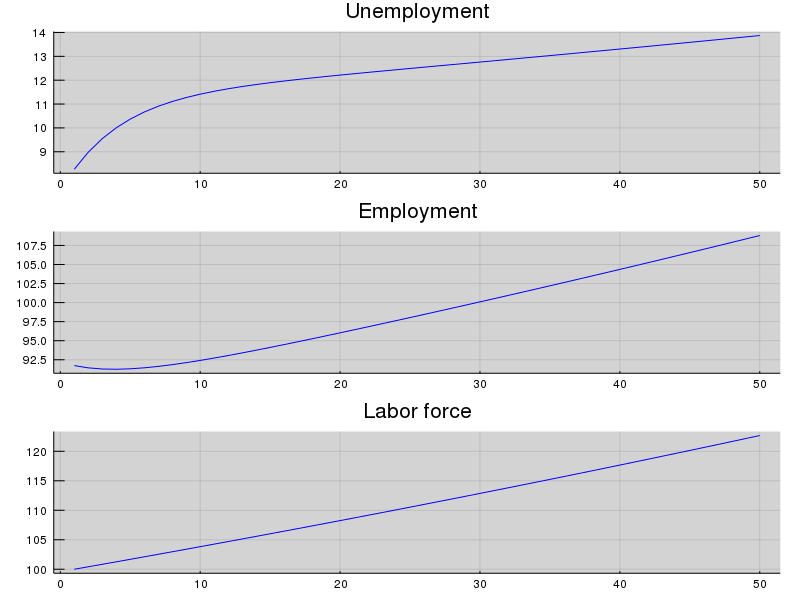

In [22]:
x1 = X_path[1, :]
x2 = X_path[2, :]
x3 = dropdims(sum(X_path, dims = 1), dims = 1)

plt_unemp = plot(title = "Unemployment", 1:T, x1, color = :blue, grid = true, label = "",
                 bg_inside = :lightgrey)
plt_emp = plot(title = "Employment", 1:T, x2, color = :blue, grid = true, label = "",
               bg_inside = :lightgrey)
plt_labor = plot(title = "Labor force", 1:T, x3, color = :blue, grid = true, label = "",
                 bg_inside = :lightgrey)

plot(plt_unemp, plt_emp, plt_labor, layout = (3, 1), size = (800, 600))

And how the rates evolve

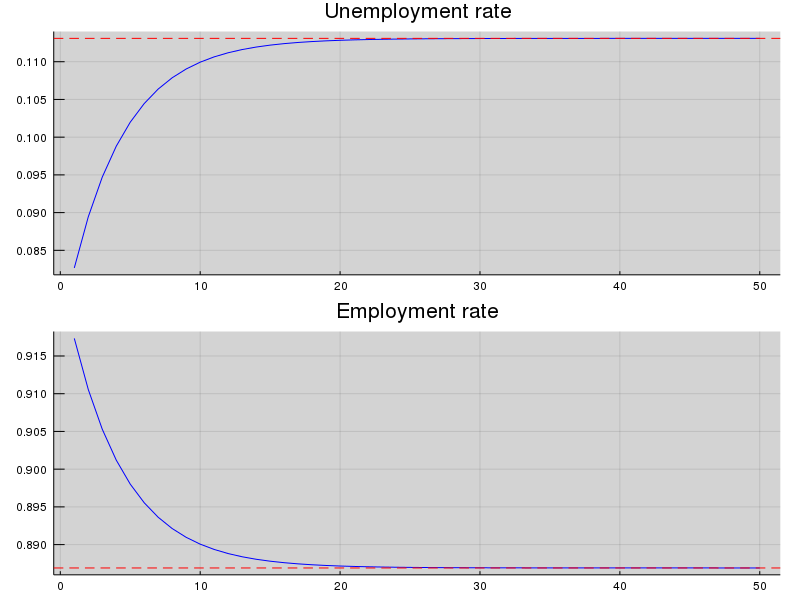

In [23]:
plt_unemp = plot(title = "Unemployment rate", 1:T, x_path[1,:], color = :blue, grid = true,
                 label = "", bg_inside = :lightgrey)
plot!(plt_unemp, [xbar[1]], linetype = :hline, linestyle = :dash, color =:red, label = "")

plt_emp = plot(title = "Employment rate", 1:T, x_path[2,:], color = :blue, grid = true,
               label = "", bg_inside = :lightgrey)
plot!(plt_emp, [xbar[2]], linetype = :hline, linestyle = :dash, color =:red, label = "")

plot(plt_unemp, plt_emp, layout = (2, 1), size = (800, 600))

We see that it takes 20 periods for the economy to converge to it’s new
steady state levels

### Exercise 2

This next exercise has the economy experiencing a boom in entrances to
the labor market and then later returning to the original levels

For 20 periods the economy has a new entry rate into the labor market

Let’s start off at the baseline parameterization and record the steady
state

In [24]:
lm = LakeModel()
x0 = rate_steady_state(lm)

2-element Array{Float64,1}:
 0.08266626766923285
 0.9173337323307671 

Here are the other parameters:

In [25]:
b̂ = 0.003
T̂ = 20

20

Let’s increase $ b $ to the new value and simulate for 20 periods

In [26]:
lm = LakeModel(b=b̂)
X_path1 = simulate_stock_path(lm, x0 * N0, T̂)   # simulate stocks
x_path1 = simulate_rate_path(lm, x0, T̂)         # simulate rates

2×20 Array{Float64,2}:
 0.0826663  0.0739981  0.0679141  …  0.0536612  0.0536401  0.0536253
 0.917334   0.926002   0.932086      0.946339   0.94636    0.946375 

Now we reset $ b $ to the original value and then, using the state
after 20 periods for the new initial conditions, we simulate for the
additional 30 periods

In [27]:
lm = LakeModel(b = 0.0124)
X_path2 = simulate_stock_path(lm, X_path1[:, end-1], T-T̂+1)    # simulate stocks
x_path2 = simulate_rate_path(lm, x_path1[:, end-1], T-T̂+1)     # simulate rates

2×31 Array{Float64,2}:
 0.0536401  0.0624842  0.0686335  …  0.0826652  0.0826655  0.0826657
 0.94636    0.937516   0.931366      0.917335   0.917335   0.917334 

Finally we combine these two paths and plot

In [28]:
x_path = hcat(x_path1, x_path2[:, 2:end])  # note [2:] to avoid doubling period 20
X_path = hcat(X_path1, X_path2[:, 2:end])

2×50 Array{Float64,2}:
  8.26663   7.36118   6.72069   6.26524  …   8.45538   8.49076   8.52628
 91.7334   92.1168   92.238    92.1769      93.8293   94.2215   94.6153 

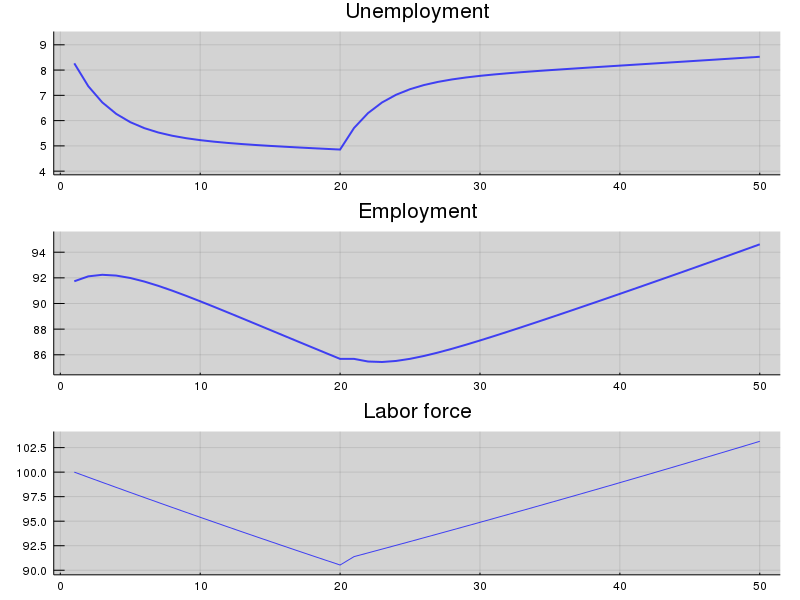

In [29]:
x1 = X_path[1,:]
x2 = X_path[2,:]
x3 = dropdims(sum(X_path, dims = 1), dims = 1)

plt_unemp = plot(title = "Unemployment", 1:T, x1, color = :blue, lw = 2, alpha = 0.7,
                 grid = true, label = "", bg_inside = :lightgrey)
plot!(plt_unemp, ylims = extrema(x1) .+ (-1, 1))

plt_emp = plot(title = "Employment", 1:T, x2, color = :blue, lw = 2, alpha = 0.7, grid = true,
               label = "", bg_inside = :lightgrey)
plot!(plt_emp, ylims = extrema(x2) .+ (-1, 1))

plt_labor = plot(title = "Labor force", 1:T, x3, color = :blue, alpha = 0.7, grid = true,
                 label = "", bg_inside = :lightgrey)
plot!(plt_labor, ylims = extrema(x3) .+ (-1, 1))
plot(plt_unemp, plt_emp, plt_labor, layout = (3, 1), size = (800, 600))

And the rates

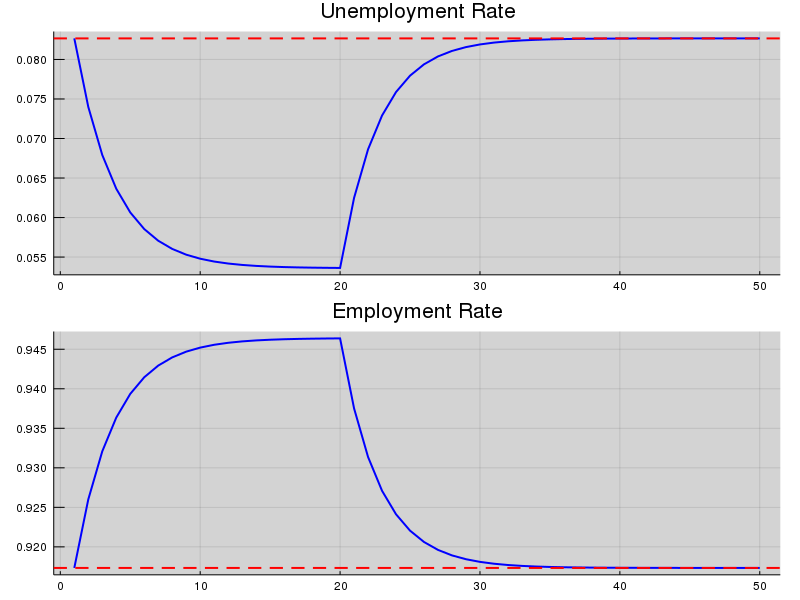

In [30]:
plt_unemp = plot(title = "Unemployment Rate", 1:T, x_path[1,:], color = :blue, grid = true,
                 label = "", bg_inside = :lightgrey, lw = 2)
plot!(plt_unemp, [x0[1]], linetype = :hline, linestyle = :dash, color =:red, label = "", lw = 2)

plt_emp = plot(title = "Employment Rate", 1:T, x_path[2,:], color = :blue, grid = true,
               label = "", bg_inside = :lightgrey, lw = 2)
plot!(plt_emp, [x0[2]], linetype = :hline, linestyle = :dash, color =:red, label = "", lw = 2)

plot(plt_unemp, plt_emp, layout = (2, 1), size = (800, 600))